# 第十次作业

## 十臂赌博机(梯度赌博机算法)    

$$\begin{equation}
\begin{aligned} 
\beta _n &= \alpha ~/ ~o_n \\
o_n &= o_{n-1} + \alpha(1-o_{n-1}) \\
&= o_{n-1}(1- \alpha) + \alpha \\
&= [o_{n-2}(1- \alpha) + \alpha](1-\alpha) + \alpha \\
&= o_{n-2}(1- \alpha)^2 + \alpha (1 - \alpha) + \alpha \\
& ... \\
&= o_1(1-\alpha)^{n-1} + \alpha(1-\alpha)^{n-2} + ...+ \alpha (1 - \alpha) + \alpha\\
&= \alpha(1-\alpha)^{n-1} + \alpha(1-\alpha)^{n-2} + ...+ \alpha (1 - \alpha) + \alpha \\
&= 1 - (1-\alpha)^{n} \\
\beta _n &= \alpha ~/ [1 - (1-\alpha)^{n}]
\end{aligned}
\end{equation}$$


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [3]:
class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1,
                  gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)
        self.time = 0
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # 每个动作的真实reward
        self.q_true = np.random.randn(self.k) + self.true_reward

        # 每个动作的估计
        self.q_estimation = np.zeros(self.k) + self.initial

        # 每个动作被选择的次数
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # 对当前赌博机选择要执行的动作
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        exp_est = np.exp(self.q_estimation)
        self.action_prob = exp_est / np.sum(exp_est)
        return np.random.choice(self.indices, p=self.action_prob)

    # 执行动作，更新动作的估值
    def step(self, action):
        # 生成动作的reward
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        one_hot = np.zeros(self.k)
        one_hot[action] = 1
        if self.gradient_baseline:
            baseline = self.average_reward
        else:
            baseline = 0
        
        # 更新估值
        beta = (self.step_size) / (1 - pow(1 - self.step_size, self.time))
        self.q_estimation += beta * (reward - baseline) * (one_hot - self.action_prob)
        return reward

In [4]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [11]:
def show(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(Bandit(step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = ['alpha = 0.1, with baseline',
              'alpha = 0.1, without baseline',
              'alpha = 0.4, with baseline',
              'alpha = 0.4, without baseline']

    for i in range(len(bandits)):
        plt.plot(best_action_counts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend(loc='lower right')

    # plt.savefig('images/figure_2_5.png')
    plt.show()
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.05it/s]


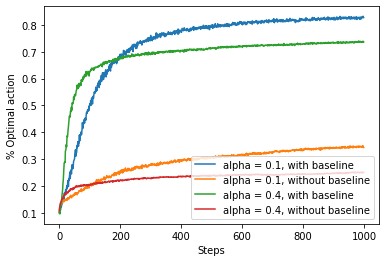

In [12]:
show()